# **Diversion Data Exploratory Analysis**

Author: Bridget Bittmann

Date Created: 09/14/2021

Date Modified: 09/14/2021

In [1]:
#Import necessary packages

import pandas as pd #to work with data arrays
!pip install geopandas
import geopandas as gpd #to work with spatial data
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [2]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Navigate to workspace

%cd /content/drive/MyDrive/spatial_colab/
%ls

/content/drive/MyDrive/spatial_colab
1986.tif  1988.tif  1990.tif  1992.tif  datasets/
1987.tif  1989.tif  1991.tif  1993.tif  pod_pou_lulcc/


In [4]:
#Import data files

div_wd63 = pd.read_csv('datasets/diversion_timeseries/WD63.csv', parse_dates=['DiversionDate'], index_col=['DiversionDate'])
print(div_wd63.dtypes)

WaterDistrictNumber             int64
HydrologyID                     int64
DiversionName                  object
DiversionTypeDescription       object
MeasurementTypeDescription     object
CFS                           float64
dtype: object


In [5]:
#Create csv file for each diversion point

div_name = np.unique(div_wd63['DiversionName']) #get unique identifier for each div point
print(div_name)

for n in div_name:
  canal = div_wd63[div_wd63['DiversionName']== n] #creates a dataframe for each canal name
  canal = canal.sort_index() #sorts data by date
  file_name = 'datasets/diversion_timeseries/'+ str(n) +'.csv' #creates a file path
  canal.to_csv(file_name) #exports csv to directory

['ANDREWS' 'ATWELL' 'Abbott 1' 'Abbott 2' 'BALLENTYNE' 'BARBER' 'BAXTER'
 'BECKLY' 'BID No 1' 'BOISE CITY' 'BOISE CITY PARKS' 'BOISE SEWER'
 'BOISE VALLEY' 'BOWMAN AND SWISHER' 'BUBB' 'Bock Creek 1'
 'Boise River ner Middleton, Id' 'CALDWELL HIGHLINE' 'CAMPBELL'
 'CANYON COUNTY' 'CAPITOL VIEW' 'CONWAY GULCH' 'CONWAY-HAMMING'
 'CRAWFORTH' 'Caldwell Lowline Canal' 'City of Placerville'
 'Clayton Lateral' 'Cummings' 'DISCOVERY PARK' 'DIXIE SLOUGH'
 'DRAINAGE DISTRICT No3' 'EAGLE DRAIN' 'EAGLE ISLAND PARK' 'EAST HARTLEY'
 'EUREKA No1' 'EUREKA No2' 'East Hartley' 'Ester Simplot Pipe'
 'FARMERS UNION' 'FISH AND GAME FLOW' 'FIVEMILE CREEK'
 'FLOOD CONTROL ACTIVE 0 - no, 1 - yes' 'Fairview Acres' 'GRAHAM-GILBERT'
 'GREEN RANCH' 'Gold Gate Irrigation' 'Grouse Creek' 'HAAS' 'HART-DAVIS'
 'HERRICK' 'INDIAN CREEK' 'ISLAND HIGHLINE' 'Idaho City' 'K ALBERTSON'
 'LEMP' 'LITTLE PIONEER' 'LONG FEEDER' 'LOWER CENTER POINT'
 'LUCKY PEAK NURSERY' 'Long Gulch' 'MACE-CATLIN' 'MACE-MACE' 'MAMMON'
 'MASON CRE

In [6]:
#Subset by known canals

ny_canal = div_wd63[div_wd63['DiversionName'] == 'NEW YORK'] #export data for new york canal
siebenberg_canal = div_wd63[div_wd63['DiversionName'] == 'SEIBENBERG'] #export data for seibenberg canal
print(ny_canal)

               WaterDistrictNumber  ...     CFS
DiversionDate                       ...        
2010-11-09                      63  ...    0.00
2010-12-14                      63  ...    0.00
2010-12-30                      63  ...    0.00
2011-01-17                      63  ...    0.00
2011-01-18                      63  ...    0.00
...                            ...  ...     ...
2021-03-27                      63  ...  737.78
2021-03-28                      63  ...  736.84
2021-03-29                      63  ...  738.39
2021-03-30                      63  ...  738.63
2021-03-31                      63  ...  732.67

[5196 rows x 6 columns]


In [7]:
#extract just a certain year from New York canal

div_wd63.head()
div_wd63.info()
div_wd63.index


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 497541 entries, 2021-04-13 to 2020-08-23
Data columns (total 6 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   WaterDistrictNumber         497541 non-null  int64  
 1   HydrologyID                 497541 non-null  int64  
 2   DiversionName               497541 non-null  object 
 3   DiversionTypeDescription    497541 non-null  object 
 4   MeasurementTypeDescription  497541 non-null  object 
 5   CFS                         497541 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 26.6+ MB


DatetimeIndex(['2021-04-13', '2021-04-07', '2021-04-08', '2021-04-09',
               '2021-04-10', '2021-04-11', '2021-04-12', '2021-05-03',
               '2021-04-27', '2021-04-28',
               ...
               '2020-08-15', '2020-08-16', '2020-08-17', '2020-08-24',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23'],
              dtype='datetime64[ns]', name='DiversionDate', length=497541, freq=None)

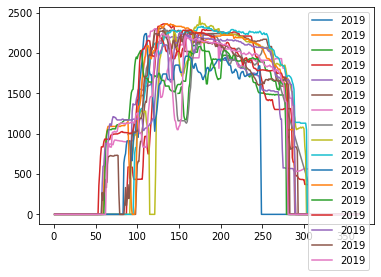

In [8]:
#Plot the timeseries

#select just the 2010 year
# ny_2010 = ny_canal[ny_canal.index.year == 2010] #index years for 2010
# ny_2010 = ny_2010.sort_index() #sort by oldest to newest
# ny_2020 = ny_canal[ny_canal.index.year == 2020] #index years for 2020
# ny_2020 = ny_2020.sort_index()

# fig1 = plt.figure(figsize=(10,7)) #create a figure
# ax = fig1.add_subplot(1,1,1) #create an axes position for subplot
# ax.plot(ny_2010.index.dayofyear, ny_2010['CFS']) #plot the data
# ax.plot(ny_2020.index.dayofyear, ny_2020['CFS'])
# ax.set_xlabel('Day of Year', fontsize = 12) #create an x-axis label
# ax.set_ylabel('Discharge (cfs)', fontsize = 12) #create a y-axis label
# plt.setp(ax.get_xticklabels(), rotation = 45) #rotate the axis to read better

#format dates so years are on top of one another
#formatdates = DateFormatter('%m-%d')
#ax.xaxis.set_major_formatter(formatdates)
#plt.show()

years = np.array(np.arange(2003,2020))

for n in years: 
  data = ny_canal[ny_canal.index.year == n]
  sort_data = data.sort_index()
  plt.plot(sort_data.index.dayofyear, sort_data['CFS']) #plot the data
  plt.legend(labels=sort_data.index.year)

  


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

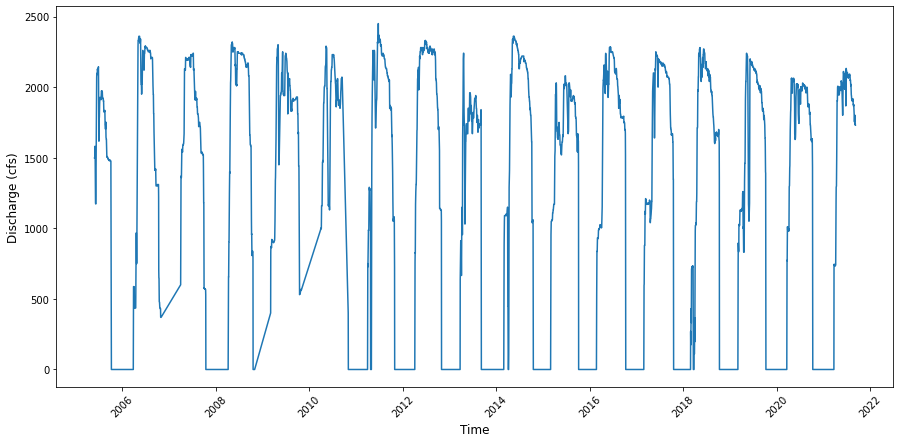

In [9]:
#plot just the new york canal

ny_canal = ny_canal.sort_index()

fig1 = plt.figure(figsize=(15,7)) #create a figure
ax = fig1.add_subplot(1,1,1) #create an axes position for subplot
ax.plot(ny_canal.index, ny_canal['CFS']) #plot the data
ax.set_xlabel('Time', fontsize = 12) #create an x-axis label
ax.set_ylabel('Discharge (cfs)', fontsize = 12) #create a y-axis label
plt.setp(ax.get_xticklabels(), rotation = 45) #rotate the axis to read better



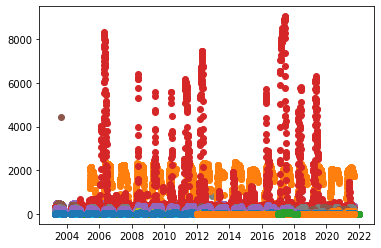

In [10]:
# figure out the names of each of the canals

hydro_id = np.unique(div_wd63['HydrologyID'])

for n in hydro_id: 
  canal = div_wd63[div_wd63['HydrologyID']== n]
  plt.scatter(canal.index, canal['CFS'])